In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics 
from datetime import datetime
sns.set(style="darkgrid")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/us-accidents/US_Accidents_Dec19.csv



Predictive models were discussed in previous file.

Here we work on different risk factors cause the accident probability per state. Combining this facts and the idea of crime prediction leads to the prediction of country per traffic accident. With this prediction of risk factors per state individual measures can defined to reduce the local risk. For a country or state agency this can be a daily tool to understand early trends and fight against individual tragically fates.  

# EDA #

For memory and training-time-reasons a sample of 500.000 records will used 

In [81]:
df_org=pd.read_csv('/kaggle/input/us-accidents/US_Accidents_Dec19.csv')
df=df_org.sample(500000, random_state =21)

### Feature Overview ###
For a first overview output of the features

### Detail View

**Geography features (input variables)**

* Start_Lat/Start_Lng: starting point of accident, floating values of coordinates
* End_Lat/End_Lng: end point of accident, floating values of coordinates
* Number/State/Street/County/Zipcode/Country: address of the accident’s location
* Airport_Code: string value of nearest airport code

These features will not include in the prediction model because the state should not be predicted by address features.


**Geography features (target variable)**

The target value for the multilabel classification is imbalance - this have to be considered later in predicition

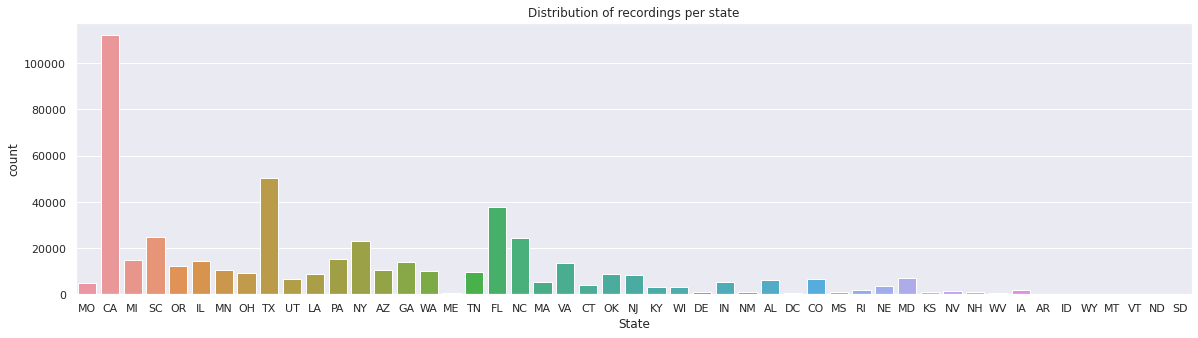

In [83]:
plt.figure(figsize=(20, 5))
plt.title('Distribution of recordings per state')
sns.countplot(x=df['State'], data=df)

**Accident-focused features**

* Severity: The severity of an accident is described as number between 1 to 4 with a mean value of 2.5 for all recordings

Text(0.5, 1.0, 'Severity distribution as histogram')

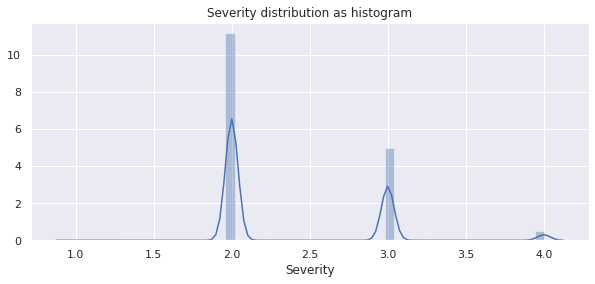

In [84]:
plt.figure(figsize=(10, 4))
plt.subplot(111)
sns.distplot(df['Severity'])
plt.title('Severity distribution as histogram')

* Distance(mi): Distance means the difference starting to end point of the accident. As visible in general nearly zero miles are recorded but some accidents have outliners

Text(0.5, 1.0, 'Distance distribution as histogram')

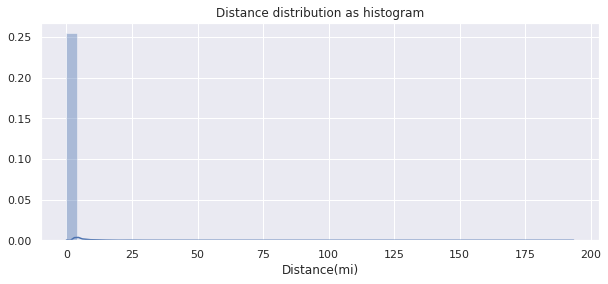

In [85]:
plt.figure(figsize=(10, 4))
plt.subplot(111)
sns.distplot(df['Distance(mi)'])
plt.title('Distance distribution as histogram')

* Description: String of an description the accident occurs like “Two right lane blocked and right hand shoulder blocked due to accident on I-270 Northbound after I-55”
* multiple features like "junction","stopping"... Boundary conditions of accident for example if there was a junction (0 for negative / 1 for positive)

In [86]:
bool_features=['Amenity',
              'Bump',
              'Crossing',
              'Give_Way',
              'Junction',
              'No_Exit',
              'Railway',
              'Roundabout',
              'Station',
              'Stop',
              'Traffic_Calming',
              'Traffic_Signal',
              'Turning_Loop']

for i in bool_features:
    df_temp=df[i].copy()
    df_temp[df_temp==False]=0
    df_temp[df_temp==True]=1
    df[i] = df_temp
    

Text(0.5, 1.0, 'Station')

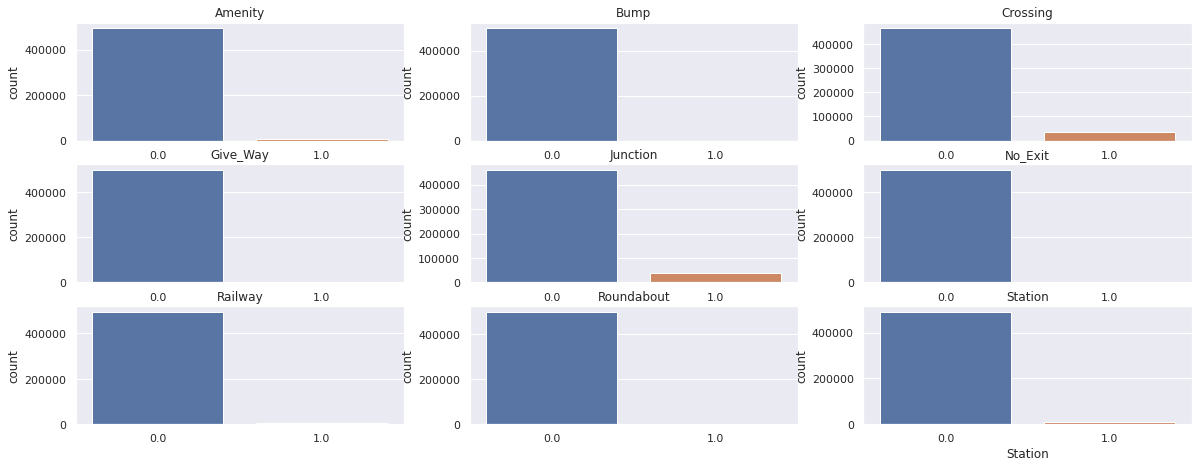

In [87]:
plt.figure(figsize=(20, 10))
plt.subplot(431)
sns.countplot(df['Amenity'])
plt.title('Amenity')
plt.xlabel('')
plt.subplot(432)
sns.countplot(df['Bump'])
plt.title('Bump')
plt.xlabel('')
plt.subplot(433)
sns.countplot(df['Crossing'])
plt.title('Crossing')
plt.xlabel('')
plt.subplot(434)
sns.countplot(df['Give_Way'])
plt.title('Give_Way')
plt.xlabel('')
plt.subplot(435)
sns.countplot(df['Junction'])
plt.title('Junction')
plt.xlabel('')
plt.subplot(436)
sns.countplot(df['No_Exit'])
plt.title('No_Exit')
plt.xlabel('')
plt.subplot(437)
sns.countplot(df['Railway'])
plt.title('Railway')
plt.xlabel('')
plt.subplot(438)
sns.countplot(df['Roundabout'])
plt.title('Roundabout')
plt.xlabel('')
plt.subplot(439)
sns.countplot(df['Station'])
plt.title('Station')

Text(0.5, 0, '')

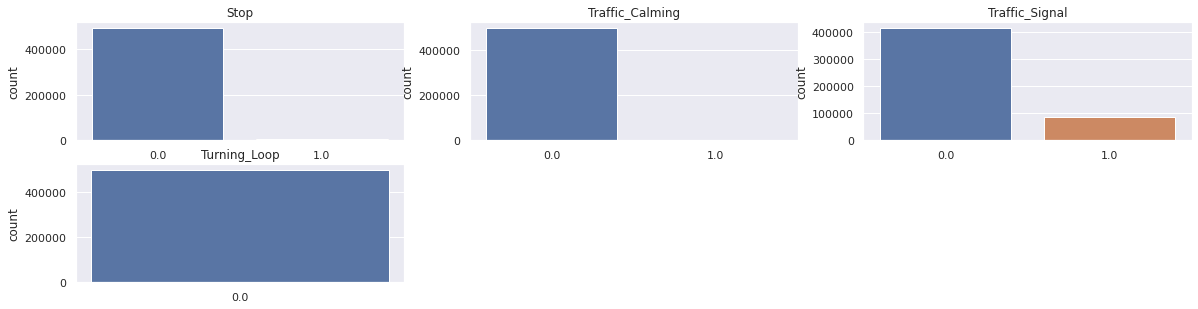

In [88]:
plt.figure(figsize=(20, 10))
plt.subplot(431)
sns.countplot(df['Stop'])
plt.title('Stop')
plt.xlabel('')
plt.subplot(432)
sns.countplot(df['Traffic_Calming'])
plt.title('Traffic_Calming')
plt.xlabel('')
plt.subplot(433)
sns.countplot(df['Traffic_Signal'])
plt.title('Traffic_Signal')
plt.xlabel('')
plt.subplot(434)
sns.countplot(df['Turning_Loop'])
plt.title('Turning_Loop')
plt.xlabel('')

**Weather features**

* Weather Timestamp: Date/time value for api-supported matching of weather dates
* Temperature: Temperature as float-value
* Wind_Chill: Temperature as float-value
* Humidity: Humidity as float-value
* Pressure: Pressure as float-value
* Visibility: Visibility in miles as float-value
* Wind_Direction: String value of wind direction, cleaned and converted as int 
* Wind_Speed: Wind speed as float-value
* Precipitation: Amount of precipitation as float-value
* Weather Condition: Description as string like “mostly cloudy”, converted as int

Data-Handling:
* For missing values the median of the features will used
* Outliners: Following outliners will not considered for prediction
* Temperature > 134°F – 134°F was the hottest recording ever in US 
* Wind speed > 253 – 253mph was the highest wind speed ever recorded in the us 
* Pressure: The lowest barometric pressure ever recorded was 25.69.  In this dataset a lot of recordings have values below – the pressure feature will not used for prediction model


In [89]:
weather_features=['Weather_Timestamp',
                  'Temperature(F)',
                  'Wind_Chill(F)',
                  'Humidity(%)',
                  'Pressure(in)',
                  'Visibility(mi)',
                  'Wind_Direction',
                  'Wind_Speed(mph)',
                  'Precipitation(in)',
                  'Weather_Condition']
print('Types')  
print(df[weather_features].info())
print('\n')
print('Count nan-values')
print(df[weather_features].isna().sum())

Types
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 988196 to 2060013
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Weather_Timestamp  493851 non-null  object 
 1   Temperature(F)     490611 non-null  float64
 2   Wind_Chill(F)      188192 non-null  float64
 3   Humidity(%)        490101 non-null  float64
 4   Pressure(in)       491962 non-null  float64
 5   Visibility(mi)     488978 non-null  float64
 6   Wind_Direction     492532 non-null  object 
 7   Wind_Speed(mph)    425910 non-null  float64
 8   Precipitation(in)  163835 non-null  float64
 9   Weather_Condition  488968 non-null  object 
dtypes: float64(7), object(3)
memory usage: 62.0+ MB
None


Count nan-values
Weather_Timestamp      6149
Temperature(F)         9389
Wind_Chill(F)        311808
Humidity(%)            9899
Pressure(in)           8038
Visibility(mi)        11022
Wind_Direction         7468
Wind_Speed(mph) 

**wind direction**

Cleaning data and factorising wind direction to numbers

In [90]:
df['Wind_Direction'].unique()

array(['NE', 'Calm', 'SW', 'NNE', 'ENE', 'West', 'South', 'North', 'VAR',
       'SE', 'W', 'WSW', 'SSE', 'Variable', 'NNW', 'SSW', 'CALM', 'NW',
       'N', 'WNW', 'ESE', nan, 'East', 'E', 'S'], dtype=object)

In [91]:
df['Wind_Direction']=df['Wind_Direction'].replace('E', 'East')
df['Wind_Direction']=df['Wind_Direction'].replace('N', 'North')
df['Wind_Direction']=df['Wind_Direction'].replace('W', 'West')
df['Wind_Direction']=df['Wind_Direction'].replace('S', 'South')
df['Wind_Direction']=df['Wind_Direction'].replace('CALM', 'Calm')

In [92]:
df['Wind_Direction'].unique()

array(['NE', 'Calm', 'SW', 'NNE', 'ENE', 'West', 'South', 'North', 'VAR',
       'SE', 'WSW', 'SSE', 'Variable', 'NNW', 'SSW', 'NW', 'WNW', 'ESE',
       nan, 'East'], dtype=object)

In [93]:
factor_wd = pd.factorize(df['Wind_Direction'])
df['Wind_Direction'] = factor_wd[0]

**weather condition**

Cleaning data and factorising wind direction to numbers

In [94]:
df['Weather_Condition'].unique()

array(['Fog', 'Clear', 'Fair', 'Scattered Clouds', 'Overcast',
       'Light Rain', 'Partly Cloudy', 'Mostly Cloudy', 'Snow',
       'Light Snow', 'Smoke', 'Cloudy', nan, 'Drizzle', 'Rain', 'Haze',
       'Heavy Rain', 'Heavy Drizzle', 'Light Drizzle', 'Heavy T-Storm',
       'Thunder', 'Light Thunderstorms and Rain', 'Heavy Snow',
       'Thunderstorm', 'Cloudy / Windy', 'Fair / Windy',
       'Mostly Cloudy / Windy', 'Light Freezing Rain', 'Mist',
       'Thunder in the Vicinity', 'Light Freezing Fog', 'Shallow Fog',
       'Thunderstorms and Rain', 'Light Rain with Thunder',
       'Showers in the Vicinity', 'Partly Cloudy / Windy',
       'Patches of Fog', 'Widespread Dust', 'T-Storm',
       'Heavy Thunderstorms and Rain', 'Heavy T-Storm / Windy',
       'Small Hail', 'Funnel Cloud', 'Light Freezing Drizzle',
       'Wintry Mix', 'Rain / Windy', 'Snow and Sleet / Windy',
       'Heavy Snow / Windy', 'Freezing Rain', 'Light Rain / Windy',
       'Blowing Snow', 'T-Storm / Windy', '

In [95]:
factor_wc = pd.factorize(df['Weather_Condition'])
df['Weather_Condition'] = factor_wc[0]

**other weather features**

The continuous values will be taken to the ML-model. The null-values will be filled with median values

In [96]:
acc_features=['Temperature(F)',
              'Wind_Chill(F)',
              'Humidity(%)',
              'Pressure(in)',
              'Visibility(mi)',
              'Wind_Speed(mph)',
              'Precipitation(in)']

for feature in acc_features:
    df[feature]=df[feature].fillna(df[feature].median())

Text(0.5, 0, '')

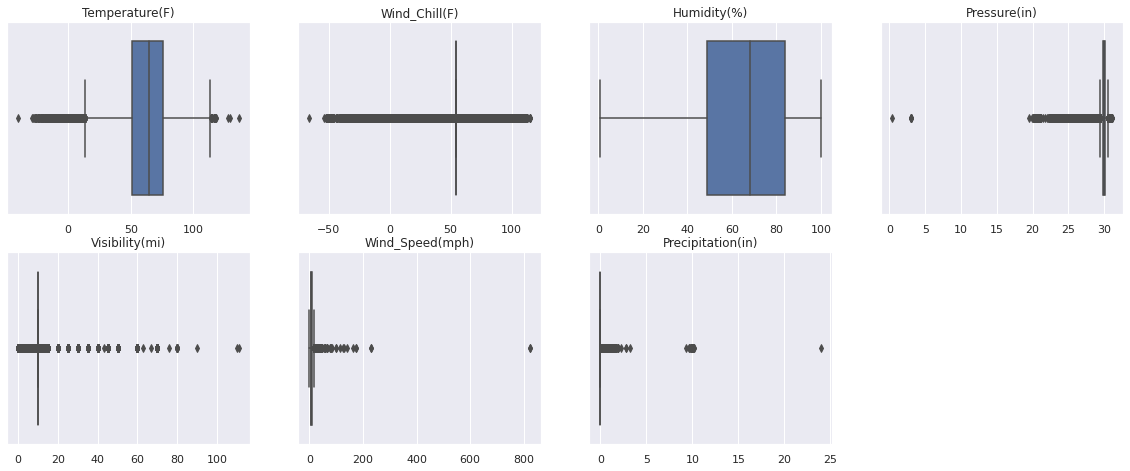

In [97]:
plt.figure(figsize=(20, 12))
plt.subplot(341)
sns.boxplot(x=df['Temperature(F)'])
plt.title('Temperature(F)')
plt.xlabel('')
plt.subplot(342)
sns.boxplot(x=df['Wind_Chill(F)'])
plt.title('Wind_Chill(F)')
plt.xlabel('')
plt.subplot(343)
sns.boxplot(x=df['Humidity(%)'])
plt.title('Humidity(%)')
plt.xlabel('')
plt.subplot(344)
sns.boxplot(x=df['Pressure(in)'])
plt.title('Pressure(in)')
plt.xlabel('')
plt.subplot(345)
sns.boxplot(x=df['Visibility(mi)'])
plt.title('Visibility(mi)')
plt.xlabel('')
plt.subplot(346)
sns.boxplot(x=df['Wind_Speed(mph)'])
plt.title('Wind_Speed(mph)')
plt.xlabel('')
plt.subplot(347)
sns.boxplot(x=df['Precipitation(in)'])
plt.title('Precipitation(in)')
plt.xlabel('')


In [98]:
df=df[df['Wind_Speed(mph)'] <= 253]
df=df[df['Temperature(F)'] <= 134]

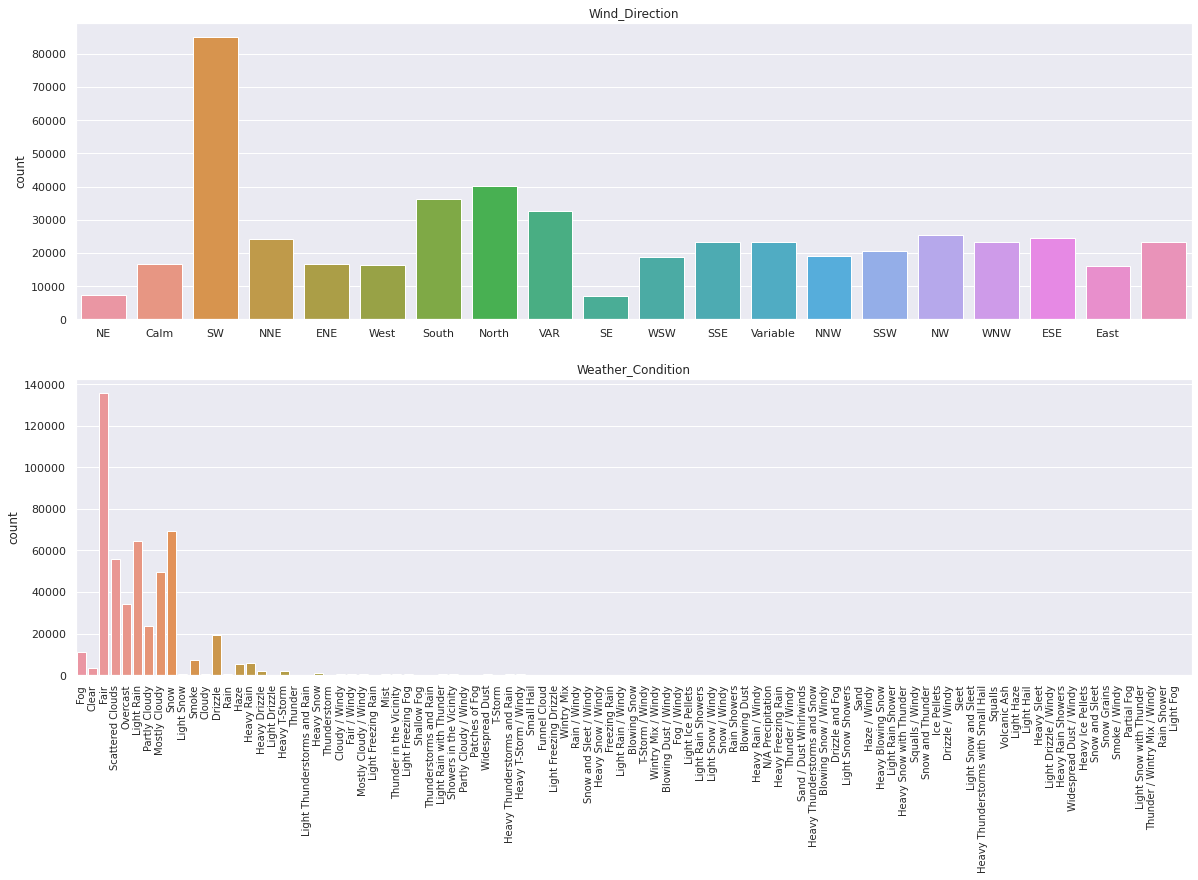

In [99]:
plt.figure(figsize=(20, 12))
plt.subplot(211)
g=sns.countplot(x=df['Wind_Direction'])
plt.title('Wind_Direction')
plt.xlabel('')
x_list=[]
for i in factor_wd[1]:
    x_list.append(i)
g.set_xticklabels(x_list)
plt.subplot(212)
o=sns.countplot(df['Weather_Condition'])
plt.title('Weather_Condition')
plt.xlabel('')
x_list=[]
for i in factor_wc[1]:
    x_list.append(i)
o.set_xticklabels(x_list, size=10, rotation=90)
plt.show()

**Time features **

* Start_Time/ End Time: Date and Time of start/end traffic accident
* Timezone: Timezone in US in the categories Pacific/Mountain/Central/Eastern. The Timezone values used for normalizing the additional feature Start_Time_hour
* Start_Time_hour: Extracted as additional feature weekday of start hour – normalized of Central timezone (Pacific Time +2 / Mountain Time +1 / Eastern Time -1) 
* Start_Time_weekday: Extracted as additional feature weekday of start time


In [100]:
df['Start_Time']=pd.to_datetime(df['Start_Time'])
df['End_Time']=pd.to_datetime(df['End_Time'])
df['Start_Time_weekday']=df['Start_Time'].dt.dayofweek
df['Start_Time_hour']=df['Start_Time'].dt.hour

In [101]:
df['Timezone'].unique()

array(['US/Central', 'US/Pacific', 'US/Eastern', 'US/Mountain', nan],
      dtype=object)

In [102]:
for row in df.index:
    if df.loc[row,'Timezone']=='US/Eastern':
        df.loc[row,'Start_Time_hour']=df.loc[row,'Start_Time_hour']-1
    elif df.loc[row,'Timezone']=='US/Pacific':
        df.loc[row,'Start_Time_hour']=df.loc[row,'Start_Time_hour']+2
    elif df.loc[row,'Timezone']=='US/Mountain':
        df.loc[row,'Start_Time_hour']=df.loc[row,'Start_Time_hour']+1

Text(0.5, 0, '')

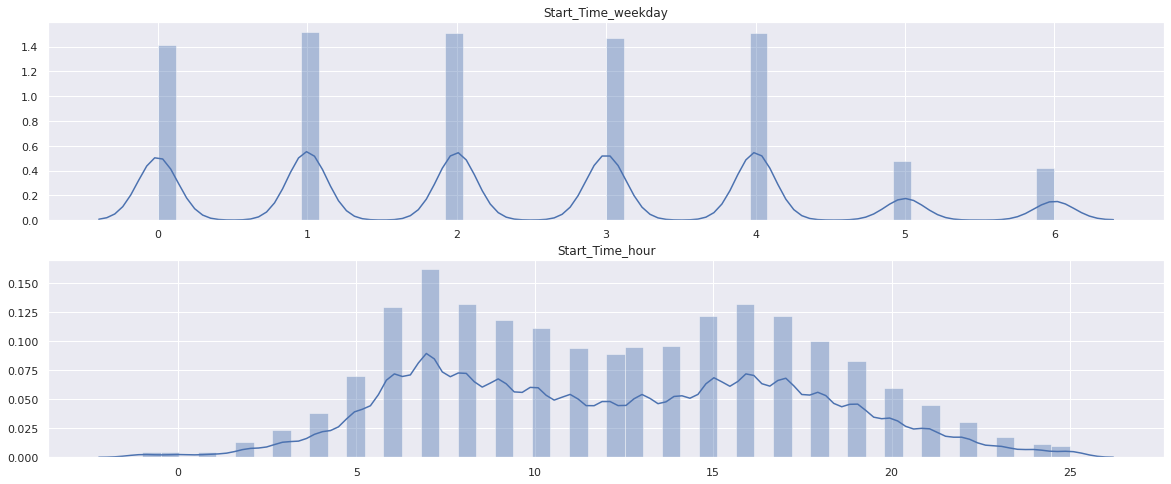

In [103]:
plt.figure(figsize=(20,8))
plt.subplot(211)
sns.distplot(df['Start_Time_weekday'])
plt.title('Start_Time_weekday')
plt.xlabel('')
plt.subplot(212)
sns.distplot(df['Start_Time_hour'])
plt.title('Start_Time_hour')
plt.xlabel('')

**Sunrise / Twilight data**

The Sunrise/Twilight data are categorical features if some nan and 0-values. The 4 columns are identical - taking only the Sunrise_Sunset column and removing the nan and 0-values with the median. Converting 0 to day and 1 to night

In [104]:
print('Number of records wth day')
print(df[df['Sunrise_Sunset']=='Day']['ID'].count())
print('Number of records wth night')
print(df[df['Sunrise_Sunset']=='Night']['ID'].count())

# Filling the nans with day

df['Sunrise_Sunset']=df['Sunrise_Sunset'].fillna('Day')
print('nans left')
print(df['Sunrise_Sunset'].isna().sum())

Number of records wth day
368874
Number of records wth night
131111
nans left
0


In [105]:
df['Sunrise_Sunset']=df['Sunrise_Sunset'].replace('Day',0)
df['Sunrise_Sunset']=df['Sunrise_Sunset'].replace('Night',1)

[Text(0, 0, 'Day'), Text(0, 0, 'Night')]

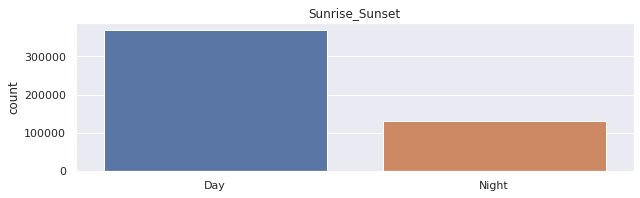

In [106]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
g=sns.countplot(x=df['Sunrise_Sunset'])
plt.title('Sunrise_Sunset')
plt.xlabel('')
g.set_xticklabels(['Day','Night'])

# Preparation #

prediction of state by accident data. Taken all available features can cause a prediction of state for example by temperature (because California is hotter as Michigan) – but perhaps a hotter temperature can also be a risk factor for accidents. 
For this reason two separate datasets will created for prediction model – one with all relevant features and a separate dataset with accident focused features. 


In [107]:
feat_columns=['State',
              'Severity',
              'Distance(mi)', 
              'Temperature(F)',
              'Wind_Chill(F)',
              'Humidity(%)',
              'Wind_Direction',
              'Weather_Condition',
              'Visibility(mi)',
              'Wind_Speed(mph)',
              'Precipitation(in)',
              'Start_Time_hour',
              'Start_Time_weekday',
              'Sunrise_Sunset',
              'Amenity',
              'Bump',
              'Crossing',
              'Give_Way',
              'Junction',
              'No_Exit',
              'Railway',
              'Roundabout',
              'Station',
              'Stop',
              'Traffic_Calming',
              'Traffic_Signal',
              'Turning_Loop']

# accident focused features 
featO_columns=['State',
              'Severity',
              'Distance(mi)',
              'Start_Time_hour',
              'Start_Time_weekday',
              'Sunrise_Sunset',
              'Weather_Condition',
              'Amenity',
              'Bump',
              'Crossing',
              'Give_Way',
              'Junction',
              'No_Exit',
              'Railway',
              'Roundabout',
              'Station',
              'Stop',
              'Traffic_Calming',
              'Traffic_Signal',
              'Turning_Loop']




# Last check    
df_feat=df[feat_columns]    
#print(df_feat.isna().sum())
print(df_feat.isna().sum())
print(df_feat.info())


State                 0
Severity              0
Distance(mi)          0
Temperature(F)        0
Wind_Chill(F)         0
Humidity(%)           0
Wind_Direction        0
Weather_Condition     0
Visibility(mi)        0
Wind_Speed(mph)       0
Precipitation(in)     0
Start_Time_hour       0
Start_Time_weekday    0
Sunrise_Sunset        0
Amenity               0
Bump                  0
Crossing              0
Give_Way              0
Junction              0
No_Exit               0
Railway               0
Roundabout            0
Station               0
Stop                  0
Traffic_Calming       0
Traffic_Signal        0
Turning_Loop          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 499997 entries, 988196 to 2060013
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   State               499997 non-null  object 
 1   Severity            499997 non-null  int64  
 2   Distance(mi)     

# Prediction with whole dataset #

In [108]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [109]:
df_feat=df[feat_columns]

In [110]:
# Convert state to numbers
factor = pd.factorize(df_feat['State'])
df_feat['State'] = factor[0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [111]:
df_feat['State'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [112]:
#Splitting the data into independent and dependent variables
target='State'
y = df_feat[target]
X = df_feat.drop(columns=target)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

In [114]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Evaluation functions**

In [115]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    print(roc_auc_score(y_test, y_pred, average=average))
    return

def multiclass_f1_score(y_test, y_pred, average="weighted"):
    f1=f1_score(y_test, y_pred, average=average)
    print(f1)
    return
    
def multiclass_classification_report(y_test, y_pred):
    list=[]
    for i in factor[1]:
        list.append(i)
    print(classification_report(y_test,y_pred,target_names=list))
    return

**RandomForestClassifier**

In [116]:
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [117]:
definitions=factor[1]
state_num= len(definitions)
y_pred = classifier.predict(X_test)

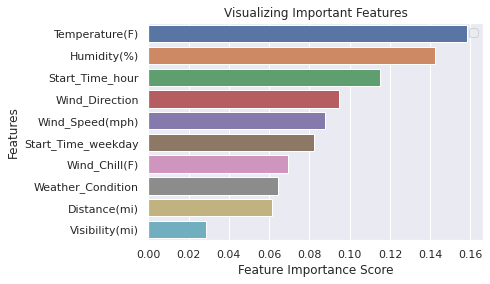

In [118]:
feature_imp = pd.Series(classifier.feature_importances_,index=X.columns).sort_values(ascending=False)

k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [119]:
print('ROC AUC Score')
print(multiclass_roc_auc_score(y_test, y_pred))
print('F1 Score')
print(multiclass_f1_score(y_test, y_pred))

ROC AUC Score
0.6603279782341223
None
F1 Score
0.3526678671709337
None


In [120]:
list=[]
for i in factor[1]:
    list.append(i)

report = classification_report(y_test, y_pred, output_dict=True, target_names=list)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('dataset_whole_report.csv')

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Prediction with accident focused dataset #

In [121]:
df_feat=df[featO_columns]

In [122]:
factor = pd.factorize(df_feat['State'])
df_feat['State'] = factor[0]
target='State'
y = df_feat[target]
X = df_feat.drop(columns=target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**RandomForestClassifier**

In [123]:
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [124]:
definitions=factor[1]
state_num= len(definitions)
y_pred = classifier.predict(X_test)

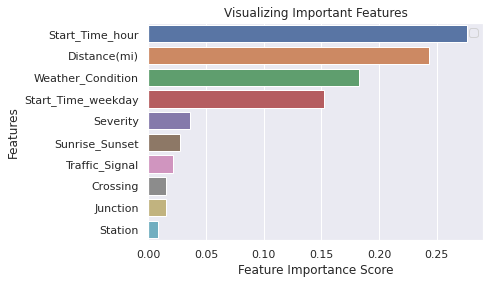

In [125]:
feature_imp = pd.Series(classifier.feature_importances_,index=X.columns).sort_values(ascending=False)

k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [126]:
print('ROC AUC Score')
print(multiclass_roc_auc_score(y_test, y_pred))
print('F1 Score')
print(multiclass_f1_score(y_test, y_pred))

ROC AUC Score
0.5824549050171298
None
F1 Score
0.21727091193409312
None


In [127]:
list=[]
for i in factor[1]:
    list.append(i)

report = classification_report(y_test, y_pred, output_dict=True, target_names=list)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('dataset_acc_report.csv')

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Benchmark model #

As benchmark the proportion will used for each state in database. 

In [162]:
df_prop_state=pd.DataFrame(columns=['State','Count','Prop'])
df_prop_state

,State,Count,Prop


In [163]:
list_state=df['State'].unique()
list_state

array(['MO', 'CA', 'MI', 'SC', 'OR', 'IL', 'MN', 'OH', 'TX', 'UT', 'LA',
       'PA', 'NY', 'AZ', 'GA', 'WA', 'ME', 'TN', 'FL', 'NC', 'MA', 'VA',
       'CT', 'OK', 'NJ', 'KY', 'WI', 'DE', 'IN', 'NM', 'AL', 'DC', 'CO',
       'MS', 'RI', 'NE', 'MD', 'KS', 'NV', 'NH', 'WV', 'IA', 'AR', 'ID',
       'WY', 'MT', 'VT', 'ND', 'SD'], dtype=object)

In [164]:
i=0
for state in list_state:
    count=len(df[df['State']== state].index)
    prop=count/len(df.index)
    df_prop_state.loc[i,'State']=state
    df_prop_state.loc[i,'Count']=count
    df_prop_state.loc[i,'Prop']=prop
    i+=1

In [165]:
df_prop_state=df_prop_state.set_index('State')

In [166]:
df_prop_state

,Count,Prop
State,,
MO,4869,0.00973806
CA,111978,0.223957
MI,14910,0.0298202
SC,24764,0.0495283
OR,12120,0.0242401
IL,14615,0.0292302
MN,10432,0.0208641
OH,9385,0.0187701
TX,50150,0.100301


# Results discussion # 

## RCF-result: whole vs. accident focused dataset ##

As shown the best performance can achieve with the Random Forrest classifier. Below the top features of the prediction with whole dataset and accident-focused dataset is compared. By using all possible features the positive result is reasoned with for example “Pressure” – which is probably not relevant as risk factor for accidents. In a closer look, the time a traffic accident happens is one state-dependent risk features. This feature with distance, weather Condition and weekday of the accident gives a state dependent feature set for prediction of accident.    

## Results to benchmark model ##

In the following table in appendix the classification report for the RCF-prediction with the whole/accident-focused dataset is used to compare the results with benchmark model. 
As visible with the f1-score the prediction quality isn’t direct related to the proportion in the dataset. For example Oregon achieved in the accident focused dataset a f1-score of 0,255 (2,4% proportion) compared to Illinoi with 0,127 (2,9% proportion).
This effect is also visible comparing the prediction results with the benchmark model. Using the whole dataset the prediction improves the result about 39%. The positive results decrease with the accident-focused dataset to about 8,9%. In this case some states performed over 25% better as the benchmark model on no states has a negative delta accident focused dataset vs. benchmark. 


In [153]:
df_report_whole=pd.read_csv('/kaggle/working/dataset_whole_report.csv', index_col=0, header=0)
df_report_acc=pd.read_csv('/kaggle/working/dataset_acc_report.csv', index_col=0, header=0)

In [172]:
df_report_whole=df_report_whole.rename(columns={'precision':'whole_df_precision'})
df_report_acc=df_report_acc.rename(columns={'precision':'acc_df_precision'})
df_compare = pd.concat([df_report_whole, df_report_acc,df_prop_state], axis=1, join='inner')
df_compare=df_compare[['whole_df_precision','acc_df_precision','Prop']]
df_compare['DELTA whole_df vs prop']=df_compare['whole_df_precision']-df_compare['Prop']
df_compare['DELTA acc vs prop']=df_compare['acc_df_precision']-df_compare['Prop']
df_compare

,whole_df_precision,acc_df_precision,Prop,DELTA whole_df vs prop,DELTA acc vs prop
MO,0.082365,0.035994,0.00973806,0.0726273,0.0262557
CA,0.549778,0.421164,0.223957,0.325821,0.197206
MI,0.210603,0.123762,0.0298202,0.180783,0.0939422
SC,0.218663,0.149592,0.0495283,0.169135,0.100063
OR,0.368846,0.284158,0.0242401,0.344606,0.259918
IL,0.237573,0.170915,0.0292302,0.208343,0.141685
MN,0.310297,0.136133,0.0208641,0.289433,0.115269
OH,0.133754,0.072080,0.0187701,0.114983,0.0533102
TX,0.348300,0.190163,0.100301,0.247999,0.0898627
UT,0.300000,0.134684,0.0136501,0.28635,0.121034


Average improvement to benchmark model

In [174]:
df_compare['DELTA acc vs prop'].mean()

0.08857585701522652

# Conclusion

Started by the historical data of 3 million traffic accidents with more than 3 million individual fates I tried to predict the state of each traffic accident. After data exploration 26 features per record remained to understand the combination of risk factors per state. In two datasets with/without geographical features, I tried different algorithms to predict the state. Compared to the benchmark model I improvement of 8,9% can achieved – in some states over 25%. 
With this prediction it is now possible to learn from the historical data to identify and avoid traffic accident risks. Taken the numbers of Oregon with over 71tsd traffic accidents in this dataset it is now possible to understand the risk factors for 18tsd traffic accidents – and try to avoid more than 18tsd individual fates.   